## Modelisation with UNET

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config_resized

# config["use_saved_model_path"] = "./model_v4_full_cat_8_large.h5"
config["val_sample_nb"] = 100
config["train_sample_nb"] = 400

config["width"] = 512
config["height"] = 256

config["epoch"] = 4

n = NotebookProcessor(config)

{
    "width": 2048,
    "height": 1024,
    "classes": 8,
    "epoch": 4,
    "batch_size": 3,
    "learning_rate": 0.001,
    "train_sample_nb": 400,
    "val_sample_nb": 100,
    "use_saved_model_path": "./model_v4_full_cat_8_large.h5",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip

- Sampling the training dataset from 2975 to 400.

- Sampling the validation dataset from 500 to 100.


2024-02-27 10:20:56.228907: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-27 10:20:56.228926: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-27 10:20:56.228929: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-27 10:20:56.228956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 10:20:56.228971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Model definition

UNET is lorem ipsum

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):  
    inputs = Input((img_height, img_width, img_channels))  
  
    # Contraction path  
    c1 = conv_block(inputs, 16)  
    p1 = MaxPooling2D((2, 2))(c1)  
      
    c2 = conv_block(p1, 32)  
    p2 = MaxPooling2D((2, 2))(c2)  
      
    c3 = conv_block(p2, 64)  
    p3 = MaxPooling2D((2, 2))(c3)  
      
    c4 = conv_block(p3, 128)  
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)  
      
    c5 = conv_block(p4, 256, 0.3)  # Increased dropout for the deepest block  
      
    # Expansive path   
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)  
    u6 = concatenate([u6, c4])  
    c6 = conv_block(u6, 128)  
       
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)  
    u7 = concatenate([u7, c3])  
    c7 = conv_block(u7, 64, 0.2)  # Modify dropout rate for specific layers if needed  
      
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)  
    u8 = concatenate([u8, c2])  
    c8 = conv_block(u8, 32)  
       
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)  
    u9 = concatenate([u9, c1])  
    c9 = conv_block(u9, 16)  
       
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)  
       
    model = Model(inputs=[inputs], outputs=[outputs])  
    return model

## Model Stats

In [3]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 2048, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 2048, 16)       448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 2048, 16)       64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 1024, 2048, 16)       0         ['batch_normalization[0][0

In [4]:
n.model_fit()

Skipping because of use_saved_model_path set in config
Loading model from config ./model_v4_full_cat_8_large.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 2048, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 2048, 16)       448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1024, 2048, 16)       0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1024, 2048, 16)       2320      ['dropout[0][

In [5]:
# n.model_save("model_delete.h5")

In [6]:
# display_loss_and_accuracy(n.model_fit_history)

1/1 [==============================] - 0s 202ms/step


2024-02-27 10:20:57.577430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Instructions for updating:
Use tf.identity with explicit device placement instead.


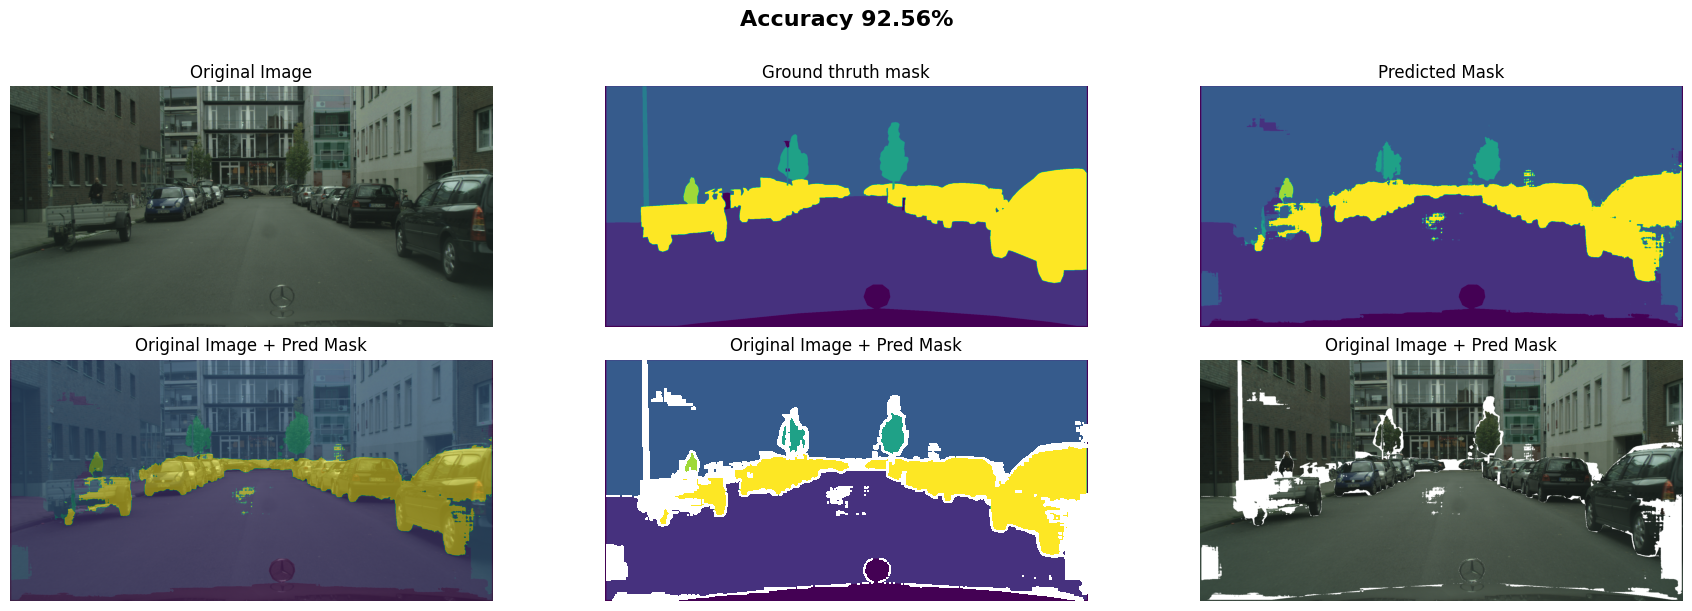

In [7]:
n.model_predict_with_display_and_accuracy(n.img["val"][3],n.mask["val"][3])

## Model Inference

1/1 [==============================] - 0s 29ms/step
AA (1024, 2048, 3)
BB (1024, 2048, 3)


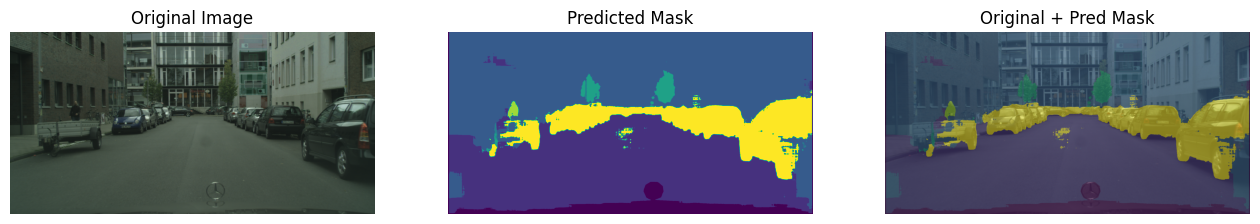

In [8]:
n.model_predict_with_display(n.img["val"][3])